In [ ]:
import tensorflow as tf

2025-05-03 20:22:52.567008: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 20:22:52.602461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-03 20:22:52.602493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-03 20:22:52.603449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 20:22:52.609560: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
import gc
tf.keras.backend.clear_session()
gc.collect()

0

In [ ]:
!pip install --upgrade transformers
!pip install tf-keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
import os
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from functools import partial
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, layers
from tensorflow.keras import Input, Model, layers

/home/featurize/tf_gpu_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
dataset_dict = load_dataset(
    "financial_phrasebank",
    "sentences_allagree",
    trust_remote_code=True
)

In [ ]:
dataset_train = dataset_dict["train"]

In [ ]:
df = dataset_train.to_pandas()

In [ ]:
model_name_distilbert_base_uncased = "distilbert-base-uncased"
tokenizer_distilbert_base_uncased = AutoTokenizer.from_pretrained(model_name_distilbert_base_uncased)
model_distilbert_base_uncased = TFAutoModelForSequenceClassification.from_pretrained(model_name_distilbert_base_uncased, num_labels=3)

2025-05-03 20:23:07.330703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-03 20:23:07.380205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-03 20:23:07.381679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
MAX_LEN = 64
BATCH_SIZE = 32
val_ratio = 0.15
test_ratio = 0.15
val_size = int(len(df) * val_ratio)
test_size = int(len(df) * test_ratio)
train_size = len(df) - val_size - test_size
texts = df['sentence'].tolist()
labels = df['label'].tolist()

In [ ]:
encodings_distilbert_base_uncased = tokenizer_distilbert_base_uncased(
    texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf'
)

dataset_distilbert_base_uncased = tf.data.Dataset.from_tensor_slices((
    dict(encodings_distilbert_base_uncased),
    tf.convert_to_tensor(labels)
)).shuffle(len(df), seed=42)

train_dataset_distilbert_base_uncased = dataset_distilbert_base_uncased.take(train_size).batch(BATCH_SIZE)
val_dataset_distilbert_base_uncased = dataset_distilbert_base_uncased.skip(train_size).take(val_size).batch(BATCH_SIZE)
test_dataset_distilbert_base_uncased = dataset_distilbert_base_uncased.skip(train_size + val_size).batch(BATCH_SIZE)

In [ ]:
train_labels_distilbert = []
for _, label in train_dataset_distilbert_base_uncased.unbatch():
    train_labels_distilbert.append(label.numpy())

class_weights_distilbert = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_distilbert),
    y=train_labels_distilbert
)
class_weight_distilbert = dict(enumerate(class_weights_distilbert))

In [ ]:
for layer in model_distilbert_base_uncased.layers:
    if 'distilbert' in layer.name:
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
model_distilbert_base_uncased.compile(metrics=['accuracy'])
model_distilbert_base_uncased.fit(train_dataset_distilbert_base_uncased, validation_data=val_dataset_distilbert_base_uncased,
                                  epochs=5,class_weight=class_weight_distilbert)

Epoch 1/5


2025-05-03 20:23:16.089688: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb77a8b03e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-03 20:23:16.089730: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-03 20:23:16.096549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-03 20:23:16.115848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1746303796.159062  325463 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 9s 46ms/step - loss: 0.8160 - accuracy: 0.6564 - val_loss: 0.7474 - val_accuracy: 0.6932
Epoch 2/5
50/50 [==============================] - 1s 26ms/step - loss: 0.5942 - accuracy: 0.7629 - val_loss: 0.4148 - val_accuracy: 0.8171
Epoch 3/5
50/50 [==============================] - 1s 26ms/step - loss: 0.5494 - accuracy: 0.7913 - val_loss: 0.3535 - val_accuracy: 0.8584
Epoch 4/5
50/50 [==============================] - 1s 26ms/step - loss: 0.5242 - accuracy: 0.8102 - val_loss: 0.4503 - val_accuracy: 0.7906
Epoch 5/5
50/50 [==============================] - 1s 26ms/step - loss: 0.4698 - accuracy: 0.8235 - val_loss: 0.3831 - val_accuracy: 0.8260


In [ ]:
model_distilbert_base_uncased.save_pretrained("exp1_checkpoint")

- ### Chapter 5: Fine-tuning a pre-trained model using LoRA （part2）
- #### 5.1 Method Description
- #### 5.2 Method Implementation
- #### 5.3 Evaluation
- ### Chapter 6 In-Depth Exploration of LoRA Fine-Tuning Techniques （part2）

### Chapter 5: Fine-tuning a pre-trained model using LoRA （part2）
This chapter focuses on applying Low-Rank Adaptation (LoRA) to fine-tune a pre-trained language model in an efficient and parameter-efficient manner. We begin with a detailed description of the LoRA methodology, explaining how it enables adaptation with minimal weight updates. The implementation section covers practical steps for integrating LoRA into the fine-tuning pipeline. Finally, we evaluate the performance of the LoRA-tuned model, comparing its results to conventional fine-tuning approaches to assess its effectiveness and efficiency.

#### 5.1 Method Description
LoRA (Low-Rank Adaptation) is a lightweight fine-tuning method that reduces the number of trainable parameters by adding two small low-rank matrices to existing weight layers, instead of updating the full model.

In practice, LoRA keeps the original model weights frozen and only trains the newly added matrices. This approach is memory-efficient and maintains strong performance, making it ideal for adapting large language models in resource-constrained settings.

#### 5.2 Method Implementation
In this section, we integrate LoRA (Low-Rank Adaptation) into a DistilBERT model for sequence classification using TensorFlow. We begin by defining a custom LoRADense layer, which wraps an existing dense layer and injects two trainable low-rank matrices—lora_A and lora_B—to capture task-specific updates. The original weights remain frozen to reduce training costs.

We initialize the model from a checkpoint and replace the feed-forward layers (ffn.lin1 and ffn.lin2) in each transformer block with our LoRADense layer. To further limit parameter updates, we freeze the embeddings and attention components, training only the LoRA parameters.

Finally, we compile the model using sparse categorical cross-entropy and train it for 5 epochs. During training, only LoRA-related parameters are updated, as confirmed by the model summary which shows zero trainable parameters in the base model.

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("exp1_checkpoint")

Some layers from the model checkpoint at exp1_checkpoint were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at exp1_checkpoint and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class LoRADense(tf.keras.layers.Layer):
    def __init__(self, orig_layer, r=8, alpha=32, **kwargs):
        super().__init__(**kwargs)

        self.orig_layer = orig_layer
        self.r = r
        self.alpha = alpha
        self.orig_layer.trainable = False  # Freeze original dense

    def build(self, input_shape):
        self.orig_layer.build(input_shape)
        in_dim = int(input_shape[-1])
        out_dim = int(self.orig_layer.units)

        self.lora_A = self.add_weight(
            shape=(in_dim, self.r),
            initializer="random_normal",
            trainable=True,
            name=self.name + "_A"
        )
        self.lora_B = self.add_weight(
            shape=(self.r, out_dim),
            initializer="zeros",
            trainable=True,
            name=self.name + "_B"
        )
        self.scaling = self.alpha / self.r

    def call(self, inputs):
        orig = self.orig_layer(inputs)
        delta = tf.matmul(tf.matmul(inputs, self.lora_A), self.lora_B) * self.scaling
        return orig + delta

In [ ]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}

In [ ]:
model.distilbert.embeddings.trainable = False

for i, layer in enumerate(model.distilbert.transformer.layer):
    layer.ffn.lin1 = LoRADense(layer.ffn.lin1, name=f"lora_lin1_{i}")
    layer.ffn.lin2 = LoRADense(layer.ffn.lin2, name=f"lora_lin2_{i}")

for i in range(model.config.n_layers):
    block = model.distilbert.transformer.layer[i]
    block.attention.trainable = False
    block.sa_layer_norm.trainable = False
    block.output_layer_norm.trainable = False

model.pre_classifier.trainable = False
model.classifier.trainable = False

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = ["accuracy"]
)

In [ ]:
history = model.fit(
    train_dataset_distilbert_base_uncased, validation_data=val_dataset_distilbert_base_uncased,
                                  epochs=5,class_weight=class_weight_distilbert
)

Epoch 1/5


/home/featurize/tf_gpu_env/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


50/50 [==============================] - 9s 66ms/step - loss: 2.4155 - accuracy: 0.3436 - val_loss: 0.8741 - val_accuracy: 0.6313
Epoch 2/5
50/50 [==============================] - 2s 38ms/step - loss: 1.2145 - accuracy: 0.4723 - val_loss: 1.1180 - val_accuracy: 0.2271
Epoch 3/5
50/50 [==============================] - 2s 38ms/step - loss: 1.2639 - accuracy: 0.4275 - val_loss: 1.1098 - val_accuracy: 0.1445
Epoch 4/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1063 - accuracy: 0.4206 - val_loss: 1.0237 - val_accuracy: 0.6254
Epoch 5/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1312 - accuracy: 0.3209 - val_loss: 1.1357 - val_accuracy: 0.2743


In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66731520  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 67324419 (256.82 MB)
Trainable params: 368640 (1.41 MB)
Non-trainable params: 66955779 (255.42 MB)
_________________________________________________________________


In [ ]:
r = 8
d_model = model.config.dim
d_model_output = model.config.hidden_dim
params_per_adapter = r * (d_model + d_model_output)
params_per_ffn_block = 2 * params_per_adapter
params_per_ffn_block

In [2]:
print("How many LoRA parameters for each FFN block: ",params_per_ffn_block)

How many LoRA parameters for each FFN block:  61440


In [ ]:
num_ffn_blocks = model.config.n_layers
added_total = num_ffn_blocks * params_per_ffn_block

In [3]:
print("How many LoRA parameters total (number of FFN blocks times the LoRA parameters per block): ",added_total)

How many LoRA parameters total (number of FFN blocks times the LoRA parameters per block): 368640


In [6]:
trainable_params = sum([np.prod(v.shape) for v in model.trainable_variables])

In [7]:
print("How many *trainable* parameters in your model: ",trainable_params)

How many *trainable* parameters in your model:  368640


In [ ]:
total_params = model.count_params()

In [8]:
print("How many total parameters in your model: ",total_params)

How many *total* parameters in your model: 67324419


In [ ]:
added_parms_calc = (768*8 + 8*3072)*2*6
assert(added_total == added_parms_calc)

#### 5.3 Evaluation

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        44
           1     0.0000    0.0000    0.0000       206
           2     0.2625    1.0000    0.4159        89

    accuracy                         0.2625       339
   macro avg     0.0875    0.3333    0.1386       339
weighted avg     0.0689    0.2625    0.1092       339



/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


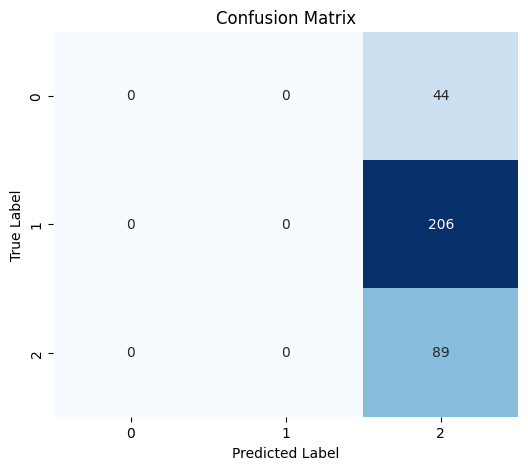

In [ ]:
y_pred = []
y_true = []
for x, label in test_dataset_distilbert_base_uncased.unbatch():
    logits = model(x).logits
    y_pred.append(np.argmax(logits))
    y_true.append(label.numpy())

y_true = np.array(y_true)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model's classification performance is notably poor. It achieves an accuracy of only 26.25%, which is significantly below the random guess level for a three-class task (approximately 33.33%). As shown in the confusion matrix, none of the instances from classes 0 or 1 were correctly predicted—all predictions were assigned to class 2.

***How does the performance of the model fine-tuned with LoRA compare to that of the pre-trained (not fine-tuned) model?***

The LoRA fine-tuned model performs worse than the original pre-trained model. While the pre-trained model shows moderate accuracy by leveraging general representations, the LoRA variant—especially at low ranks—tends to overfit or collapse into predicting dominant classes, resulting in degraded performance metrics (e.g., macro F1 < 0.2 in some cases).

***How does the performance of the model fine-tuned with LoRA compare to that of the model fine-tuned using the conventional approach?***

Compared to full-parameter fine-tuning, the LoRA-tuned model also performs worse overall. The conventional fine-tuned model achieves higher accuracy, better recall across all classes, and more balanced predictions, as seen in the confusion matrix and classification report. In contrast, the LoRA model struggles to generalize, especially on minority classes.

### Chapter 6 In-Depth Exploration of LoRA Fine-Tuning Techniques （part2）

Some layers from the model checkpoint at exp1_checkpoint were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at exp1_checkpoint and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


/home/featurize/tf_gpu_env/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


50/50 [==============================] - 8s 59ms/step - loss: 2.6405 - accuracy: 0.3310 - val_loss: 1.4801 - val_accuracy: 0.1298
Epoch 2/5
50/50 [==============================] - 2s 39ms/step - loss: 1.1773 - accuracy: 0.3878 - val_loss: 1.2885 - val_accuracy: 0.1150
Epoch 3/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1151 - accuracy: 0.3436 - val_loss: 1.0416 - val_accuracy: 0.6136
Epoch 4/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1295 - accuracy: 0.3638 - val_loss: 1.1282 - val_accuracy: 0.2507
Epoch 5/5
50/50 [==============================] - 2s 38ms/step - loss: 1.0998 - accuracy: 0.3562 - val_loss: 1.0535 - val_accuracy: 0.5929
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        52
           1     0.6047    1.0000    0.7537       205
           2     0.0000    0.0000    0.0000        82

    accuracy                         0.6047       339
   macro avg     0.2016    0.3333    0

/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


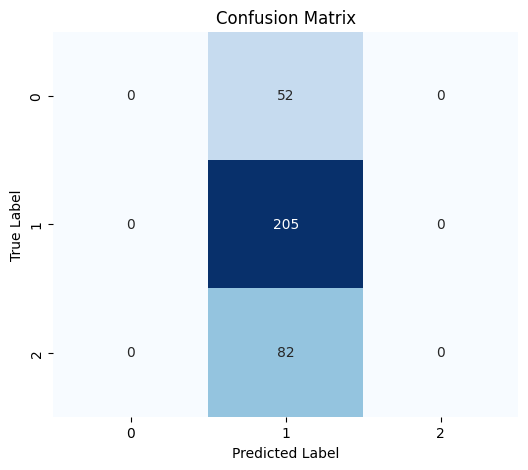

Some layers from the model checkpoint at exp1_checkpoint were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at exp1_checkpoint and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


/home/featurize/tf_gpu_env/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


50/50 [==============================] - 9s 60ms/step - loss: 2.3737 - accuracy: 0.3335 - val_loss: 1.0365 - val_accuracy: 0.6224
Epoch 2/5
50/50 [==============================] - 2s 38ms/step - loss: 1.2583 - accuracy: 0.3663 - val_loss: 1.1330 - val_accuracy: 0.2566
Epoch 3/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1005 - accuracy: 0.3657 - val_loss: 1.1871 - val_accuracy: 0.2389
Epoch 4/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1087 - accuracy: 0.4067 - val_loss: 1.1194 - val_accuracy: 0.1386
Epoch 5/5
50/50 [==============================] - 2s 37ms/step - loss: 1.0904 - accuracy: 0.4212 - val_loss: 1.0772 - val_accuracy: 0.2478
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        49
           1     0.0000    0.0000    0.0000       211
           2     0.2330    1.0000    0.3780        79

    accuracy                         0.2330       339
   macro avg     0.0777    0.3333    0

/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/featurize/tf_gpu_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


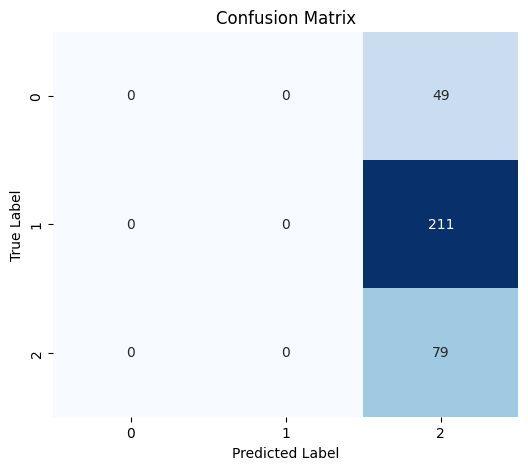

Some layers from the model checkpoint at exp1_checkpoint were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at exp1_checkpoint and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


/home/featurize/tf_gpu_env/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


50/50 [==============================] - 8s 59ms/step - loss: 2.4556 - accuracy: 0.3745 - val_loss: 1.4208 - val_accuracy: 0.3215
Epoch 2/5
50/50 [==============================] - 2s 37ms/step - loss: 1.1045 - accuracy: 0.5126 - val_loss: 1.0921 - val_accuracy: 0.6785
Epoch 3/5
50/50 [==============================] - 2s 37ms/step - loss: 0.9491 - accuracy: 0.6665 - val_loss: 1.8167 - val_accuracy: 0.2389
Epoch 4/5
50/50 [==============================] - 2s 37ms/step - loss: 0.7824 - accuracy: 0.7018 - val_loss: 0.5040 - val_accuracy: 0.7493
Epoch 5/5
50/50 [==============================] - 2s 37ms/step - loss: 0.6349 - accuracy: 0.8001 - val_loss: 1.0660 - val_accuracy: 0.6755
              precision    recall  f1-score   support

           0     0.6627    0.9649    0.7857        57
           1     1.0000    0.6359    0.7774       206
           2     0.5120    0.8421    0.6368        76

    accuracy                         0.7375       339
   macro avg     0.7249    0.8143    0

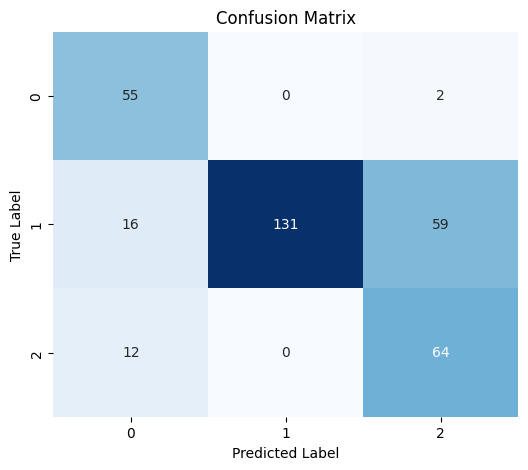

Some layers from the model checkpoint at exp1_checkpoint were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at exp1_checkpoint and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


/home/featurize/tf_gpu_env/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


50/50 [==============================] - 9s 75ms/step - loss: 2.0137 - accuracy: 0.3474 - val_loss: 3.9340 - val_accuracy: 0.2271
Epoch 2/5
50/50 [==============================] - 2s 37ms/step - loss: 1.3482 - accuracy: 0.3796 - val_loss: 1.1464 - val_accuracy: 0.2360
Epoch 3/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1398 - accuracy: 0.5259 - val_loss: 1.5488 - val_accuracy: 0.2684
Epoch 4/5
50/50 [==============================] - 2s 38ms/step - loss: 1.1366 - accuracy: 0.5523 - val_loss: 0.7063 - val_accuracy: 0.7050
Epoch 5/5
50/50 [==============================] - 2s 38ms/step - loss: 0.8700 - accuracy: 0.6475 - val_loss: 0.6666 - val_accuracy: 0.7434
              precision    recall  f1-score   support

           0     0.3968    0.9804    0.5650        51
           1     0.9415    0.9461    0.9438       204
           2     0.1250    0.0119    0.0217        84

    accuracy                         0.7198       339
   macro avg     0.4878    0.6461    0

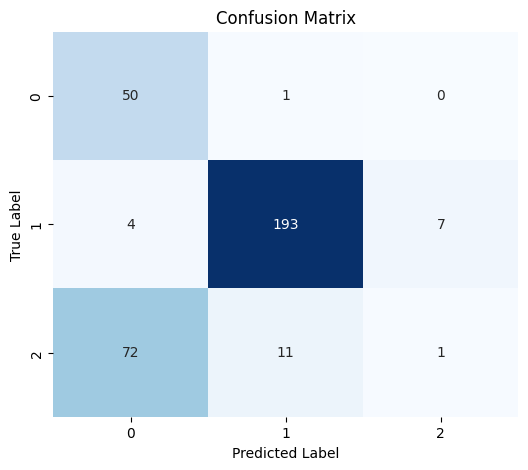

In [ ]:
for r in [2, 4, 16, 32]:
    model = TFAutoModelForSequenceClassification.from_pretrained("exp1_checkpoint")
    model.distilbert.embeddings.trainable = False
    for i, layer in enumerate(model.distilbert.transformer.layer):
        layer.ffn.lin1 = LoRADense(layer.ffn.lin1,r=r, name=f"lora_lin1_{i}")
        layer.ffn.lin2 = LoRADense(layer.ffn.lin2,r=r, name=f"lora_lin2_{i}")

    for i in range(model.config.n_layers):
        block = model.distilbert.transformer.layer[i]
        block.attention.trainable = False
        block.sa_layer_norm.trainable = False
        block.output_layer_norm.trainable = False

    model.pre_classifier.trainable = False
    model.classifier.trainable = False
    model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics   = ["accuracy"]
    )
    history = model.fit(
      train_dataset_distilbert_base_uncased, validation_data=val_dataset_distilbert_base_uncased,
                                epochs=5,class_weight=class_weight_distilbert
    )
    y_pred = []
    y_true = []
    for x, label in test_dataset_distilbert_base_uncased.unbatch():
      logits = model(x).logits
      y_pred.append(np.argmax(logits))
      y_true.append(label.numpy())

    y_true = np.array(y_true)

    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

***How does the Performance Metric change with rank?***


As the LoRA rank increases, the model performance initially improves, then slightly degrades at the highest tested rank:

* Low rank (2, 4): Performance is poor due to underfitting. The model lacks sufficient capacity to adapt, often defaulting to a single dominant class (label 1).

* Mid rank (16): Achieves the best overall performance, with high macro and weighted F1-scores, and balanced class-wise predictions.

* High rank (32): Slight drop in performance, especially on minority classes (e.g., label 2), indicating potential overfitting or diminished returns.